# Random Forest Forecasting of Sunspot Area

This notebook trains a Random Forest regressor to forecast sunspot area from historical daily observations.

**What this notebook does:**
1. Loads daily sunspot area data.
2. Cleans and interpolates missing values.
3. Aggregates the data to monthly values and applies smoothing.
4. Builds lagged features (past values) to predict future sunspot area.
5. Trains a Random Forest model and evaluates its performance.
6. Plots the actual vs predicted sunspot area over time.


## 1. Load daily sunspot area data

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Preview the daily sunspot area data

This cell loads the daily sunspot area dataset and displays the first few rows.

In [ ]:
# Daily Area Data (North/South)
filepath = "C:\\Users\\Alfie\\NN\\Time Series\\daily_area.txt"
df_whole = pd.read_csv(filepath, sep='\s+', engine='python')

## 3. Clean and preprocess the time series

In [4]:
# Replace -1 and 0 with np.nan for specified columns
columns_to_interpolate = ['Total', 'North', 'South']
df_whole[columns_to_interpolate] = df_whole[columns_to_interpolate].replace([-1, 0], np.nan)

# Ensure columns are numeric
df_whole[columns_to_interpolate] = df_whole[columns_to_interpolate].astype(float)

# Apply forward and backward fill to handle large gaps
df_whole[columns_to_interpolate] = df_whole[columns_to_interpolate].ffill().bfill()

# Apply linear interpolation
df_whole[columns_to_interpolate] = df_whole[columns_to_interpolate].interpolate(method='linear')

In [5]:
# suppress irrelevant warnings
warnings.filterwarnings("ignore", message="ERFA function.*dubious year.*")

# Convert dates to Julian Day
def gregorian_to_julian(year, month, day):
    dt = datetime(int(year), int(month), int(day))
    t = Time(dt, scale='utc')
    return t.jd

# Adds 'Julian Day' column to dataframe
df_whole['Julian_Day'] = df_whole.apply(lambda row: gregorian_to_julian(row['YYYY'], row['MM'], row['DD']), axis=1)

In [6]:
# Convert 'YYYY', 'MM', 'DD' to datetime
df_whole['Date'] = pd.to_datetime(df_whole[['YYYY', 'MM', 'DD']].astype(str).agg('-'.join, axis=1))

# Set the 'Date' column as the index
df_whole.set_index('Date', inplace=True)

# Resample to monthly averages
monthly_averages = df_whole.resample('MS').mean()

# Save the monthly averages to a new dataframe
df_monthly = monthly_averages.reset_index()

# Define the 13-month tapered-boxcar smoothing function
def tapered_boxcar_smoothing(series):
    weights = np.array([0.5] + [1]*11 + [0.5])
    weights /= weights.sum()
    return np.convolve(series, weights, mode='valid')

# Apply the smoothing function to each column
smoothed_total = tapered_boxcar_smoothing(monthly_averages['Total'])
smoothed_north = tapered_boxcar_smoothing(monthly_averages['North'])
smoothed_south = tapered_boxcar_smoothing(monthly_averages['South'])

# Create a new dataframe with the smoothed values
df_smooth = pd.DataFrame({
    'Date': monthly_averages.index[6:-6],  
    'Smoothed_Total': smoothed_total,
    'Smoothed_North': smoothed_north,
    'Smoothed_South': smoothed_south
})

## 4. Plot learning data

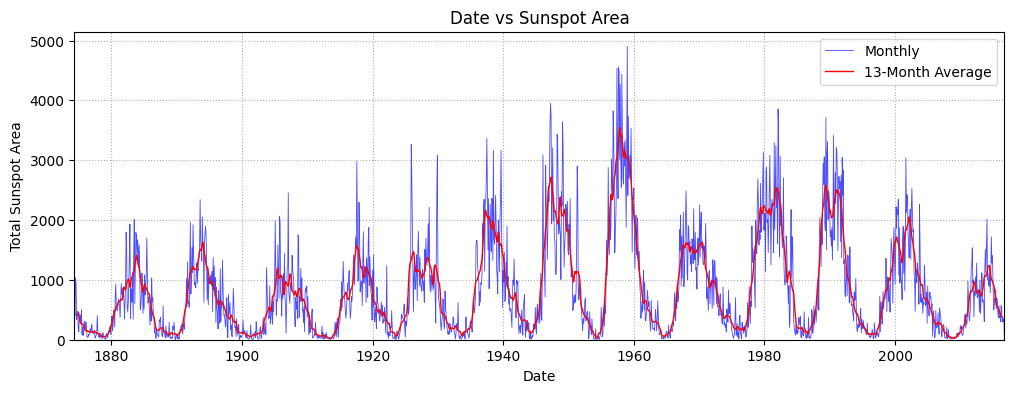

In [8]:
# Data 
plt.figure(figsize=(12, 4))
plt.plot(df_monthly['Date'], df_monthly['Total'], linestyle='-', color='Blue', alpha=0.7, linewidth=0.6,label=f'Monthly')
plt.plot(df_smooth['Date'], df_smooth['Smoothed_Total'], linestyle='-', color='Red', linewidth=1, label=f'13-Month Average')

# Customisations
plt.title('Date vs Sunspot Area')
plt.xlabel('Date')
plt.ylabel('Total Sunspot Area')
plt.xlim(left=df_monthly['Date'].min())  
plt.xlim(right=df_monthly['Date'].max()) 
plt.ylim(bottom=0)
plt.grid(True, linestyle=':')
plt.legend()
plt.show()

In [7]:
# Define train/test split for time-series forecasting
train_test_size = int(0.7 * len(df_monthly)) 

# just reduce the size of the array
df = df_monthly[:train_test_size]

## 5. Train the Random Forest model


### Hyperparameter search for lag length

This section tests different lag values to determine how many past months provide the best predictive performance.


In [ ]:
# Define the range of lag values and the number of iterations for n_estimators
import time

lag_values = [1000]
estimator_values = [1] + list(range(25, 1001, 25))

# List to store the results
results_list = []

# Loop through each lag value
for lag in lag_values:
    # Create input-output pairs for predicting total sunspots
    X = []
    Y = []

    # Iterate through the DataFrame to create lagged input-output pairs
    for i in range(len(df) - lag):
        # Input: Previous lag time steps
        X.append(df.iloc[i:i + lag]['Total'].values)
        # Output: Next time step
        Y.append(df.iloc[i + lag]['Total'])

    # Convert lists to arrays
    X = np.array(X)
    Y = np.array(Y)

    # Split into training (70%) and testing (30%)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # Loop through values for n_estimators and calculate the RMSE
    for n_estimators in estimator_values:
        
        # Record the start time
        start_time = time.time()
        
        # Create and train the RandomForest model for Total sunspots
        rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rf_model.fit(X_train, Y_train)
        
        # Evaluate RandomForest on the test set for Total sunspots
        Y_pred = rf_model.predict(X_test)
        
        # Calculate the root mean squared error
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        
        # Store the results in the list
        results_list.append({'Lag': lag, 'Estimators': n_estimators, 'RMSE': rmse})
        
        # Record the end time
        end_time = time.time()

        # Calculate the duration of training
        duration = end_time - start_time
         
        # Print the lag, number of trees, and duration
        print(f'Lag: {lag}, Trees: {n_estimators}, Time: {duration:.2f} seconds')

# Convert the list to a DataFrame
results = pd.DataFrame(results_list)

Lag: 1000, Trees: 1, Time: 0.09 seconds
Lag: 1000, Trees: 25, Time: 1.66 seconds
Lag: 1000, Trees: 50, Time: 3.35 seconds


The row with the minimum value in column 'B' is:
Lag           250.000000
Estimators     65.000000
RMSE          388.723529
Name: 559, dtype: float64
Minimum RMSE: 388.723529340824


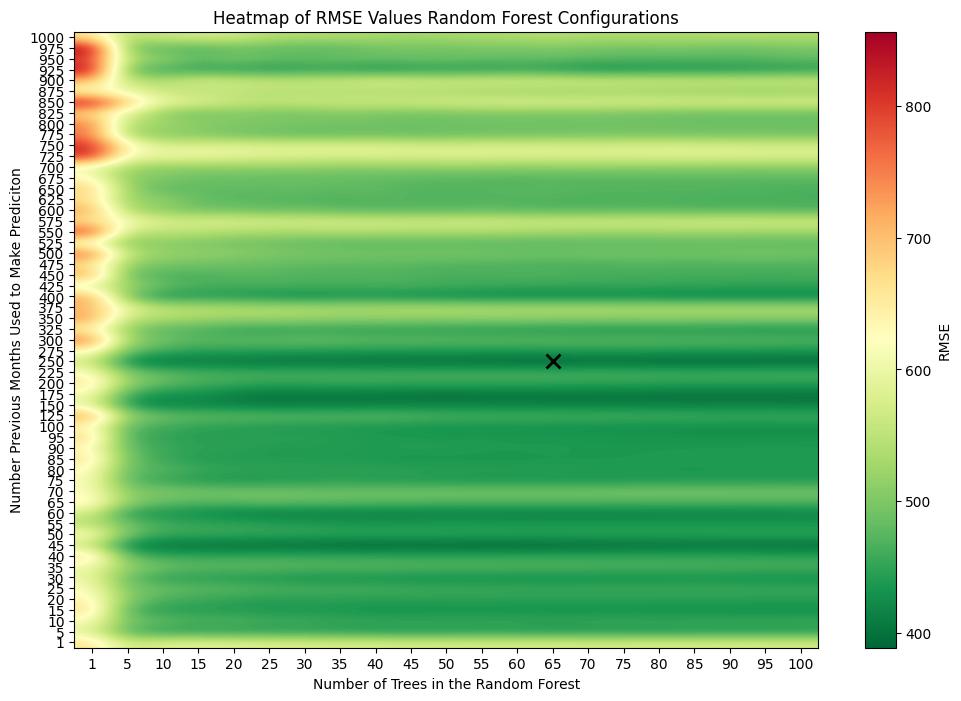

In [37]:
# heatmap for optimal lag/trees
import seaborn as sns
from matplotlib.colors import LogNorm

min_index = results['RMSE'].idxmin()

# Access the entire row with the minimum value
min_row = results.loc[min_index]

# Print the result
print(f"The row with the minimum value in column 'B' is:\n{min_row}")
print(f'Minimum RMSE: {min_RMSE}')

# Pivot the DataFrame to get Lag and Estimators as the matrix indices
results_pivot = results.pivot(index="Lag", columns="Estimators", values="RMSE")

# Plotting the heatmap with interpolation
plt.figure(figsize=(12, 8))
heatmap = plt.imshow(results_pivot, cmap="RdYlGn_r", interpolation='bicubic', aspect='auto')
plt.colorbar(heatmap, label='RMSE')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel('Number of Trees in the Random Forest')
plt.ylabel('Number Previous Months Used to Make Prediciton')
plt.title('Heatmap of RMSE Values Random Forest Configurations')
plt.xticks(ticks=np.arange(len(estimator_values)), labels=estimator_values)
plt.yticks(ticks=np.arange(len(lag_values)), labels=lag_values)

# Add the cross marker
plt.plot(13, 26, marker='x', color='black', markersize=10, markeredgewidth=2)

plt.show()

In [8]:
# Define the optimal lag value
lag = 250

# Create input-output pairs for predicting total sunspots
X = []
Y = []

# Iterate through the DataFrame to create lagged input-output pairs
for i in range(len(df) - lag):
    # Input: Previous 25 time steps
    X.append(df.iloc[i:i + lag]['Total'].values)
    # Output: Next time step
    Y.append(df.iloc[i + lag]['Total'])

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

# Split into training (70%) and testing (30%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Create and train the RandomForest model for Total sunspots
rf_model = RandomForestRegressor(n_estimators=65, random_state=42)
rf_model.fit(X_train, Y_train)

# Evaluate RandomForest on the test set for Total sunspots
Y_pred = rf_model.predict(X_test)

## 6. Evaluate model performance

In [9]:
rf_mse = mean_squared_error(Y_test, Y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(Y_test, Y_pred)
rf_r2 = r2_score(Y_test, Y_pred)

print(f"RandomForest Performance on the test set for Total Sunspot Areas:")
print(f"Mean Squared Error: {rf_mse}")
print(f"Root Mean Squared Error: {rf_rmse}")
print(f"Mean Absolute Error: {rf_mae}")
print(f"R-squared: {rf_r2}")

RandomForest Performance on the test set for Total Sunspot Areas:
Mean Squared Error: 151105.98226318645
Root Mean Squared Error: 388.723529340824
Mean Absolute Error: 266.57133468278954
R-squared: 0.7797265548912042


In [23]:
# takes the remaining part of the array and finds length
df_future = df_monthly[train_test_size:]
forecast_steps = len(df_future)
forecast = []

# Start with the last 'lag' values from the dataset
last_values = df['Total'].values[-lag:].tolist()

# loops length of dataset
for _ in range(forecast_steps):
    
    # Prepare the input for the model
    input_features = np.array(last_values[-lag:]).reshape(1, -1)
    
    # Predict the next value
    next_prediction = rf_model.predict(input_features)[0]
    
    # Append the prediction to the forecast list
    forecast.append(next_prediction)
    
    # Update the last_values list with the new prediction
    last_values.append(next_prediction)

# get end of smoothed data
smoothed_predictions = df_smooth[train_test_size:]

# Creates a new dataframe of Date, Actual and Prediciton
forecast_df = pd.DataFrame({
    'Date': df_future['Date'],
    'Monthly': df_future['Total'],
    'Prediction': forecast,
    '13-Month': smoothed_predictions['Smoothed_Total']
})

# Print the first few rows of the DataFrame to inspect
print(forecast_df.head())

# Save the DataFrame to a .txt file
forecast_df.to_csv('RandomForest.txt', sep='\t', index=False)

           Date     Monthly  Prediction    13-Month
1197 1974-02-01  253.535714  237.425986  391.318334
1198 1974-03-01  128.483871  277.767548  383.121953
1199 1974-04-01  513.533333  238.670067  360.424283
1200 1974-05-01  385.064516  200.112514  326.645968
1201 1974-06-01  292.633333  184.049130  305.688486


## 7. Plot actual vs predicted values


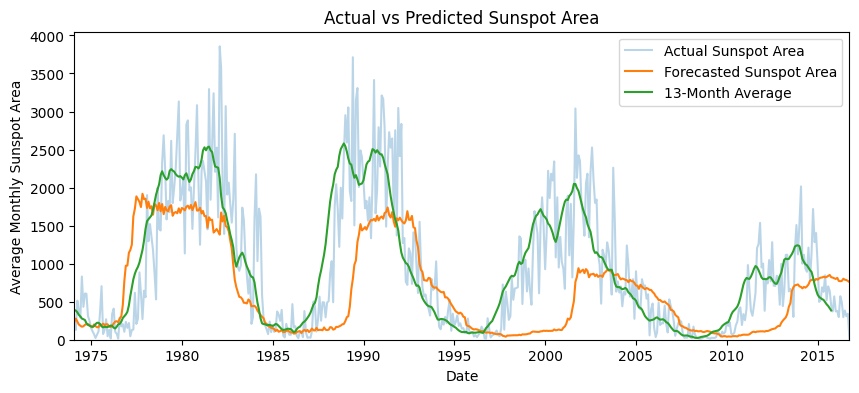

In [14]:
# Plot actual vs predicted for sunspots
plt.figure(figsize=(10, 4))
plt.plot(df_future['Date'], df_future['Total'], label='Actual Sunspot Area', alpha=0.3)
plt.plot(df_future['Date'], forecast, label='Forecasted Sunspot Area')
plt.plot(df_future['Date'], forecast_df['13-Month'], label='13-Month Average')

plt.xlabel('Date')
plt.ylabel('Average Monthly Sunspot Area')
plt.title('Actual vs Predicted Sunspot Area')
plt.xlim(left=df_future['Date'].min())  
plt.xlim(right=df_future['Date'].max()) 
plt.ylim(bottom=0)
plt.legend()
plt.show()